# RNN ile Havayolu Yolcu Sayısı Tahmini

* İş Problemi (Business Problem)
* Veriyi Anlamak (Data Understanding)
* Veriyi Hazırlamak (Data Preparation)
* Modelleme (Modeling)
* DeğerIendirme (Evaluation)

**İş Problemi**

* *Mont* => Aylık olarak yer alan tarih değişkendir.
* *Passengers* => İlgili işlem tarihindeki yolcu sayısını, yani aylık yolcu sayısını temsil etmektedir.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
df = pd.read_csv("C:/Users/ASUS/Desktop/YAZ KAMPI/8 - Derin Öğrenme/international-airline-passengers.csv")

In [3]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [5]:
df.columns = ["Month", "Passengers"]

In [6]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [7]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [8]:
df.shape

(145, 2)

In [9]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [10]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


 **Veriyi Hazırlamak**

In [12]:
df = df[:144]

In [13]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [15]:
df["Month"] = pd.to_datetime(df["Month"])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [17]:
print("Minimum Tarih : " , df["Month"].min())
print("Miksimum Tarih : " , df["Month"].max())

Minimum Tarih :  1949-01-01 00:00:00
Miksimum Tarih :  1960-12-01 00:00:00


In [18]:
df.index = df["Month"]

In [19]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [20]:
df.drop(["Month"], axis = 1, inplace = True)

In [21]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [22]:
result_df = df.copy()

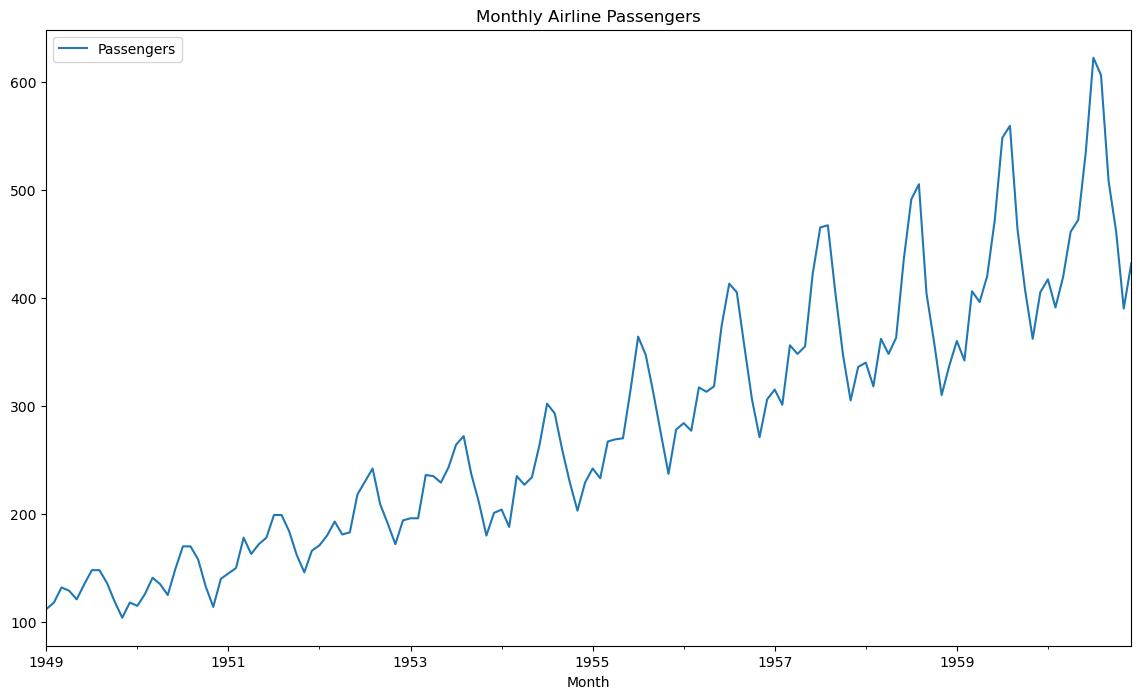

In [23]:
df.plot(figsize=(14,8), title = "Monthly Airline Passengers");

In [24]:
data = df["Passengers"].values

In [25]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [26]:
type(data[0:5]) # pandas -> numpy array'a çevirdik

numpy.ndarray

In [27]:
type(data[0])

numpy.float64

In [28]:
data = data.astype('float32')

In [29]:
type(data[0])

numpy.float32

In [30]:
data.shape

(144,)

In [31]:
data = data.reshape(-1,1)
# -1 -> 144
# 1 -> 1 (istenilen sütun sayısı)

In [32]:
data.shape

(144, 1)

In [33]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1 - test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [34]:
train, test, position = split_data(data, 0.33)

In [35]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [36]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [37]:
train = scaler_train.fit_transform(train)

In [38]:
scaler_test = MinMaxScaler(feature_range = (0,1))

In [39]:
test = scaler_test.fit_transform(test)

In [40]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [41]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [42]:
def create_features(data, lookback): # lookback => şu kadar geriye bak
    X, Y = [], []
    
    for i in range (lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i,0])
        
    return np.array(X), np.array(Y)     

In [43]:
lookback = 1

In [44]:
X_train, y_train = create_features(train, lookback)

In [45]:
X_test, y_test = create_features(test, lookback)

In [46]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


**RNN : BANA GÖNDERECEĞİNİZ VERİ 3 BOYUTLU OLMALI**

**************

**Modelleme**

In [47]:
model = Sequential()

model.add(SimpleRNN(units = 50,
                   activation = 'relu',
                   input_shape = (X_train.shape[1], lookback)))

model.add(Dropout(0.2))

model.add(Dense(1))
# Çıkış katmanında tek bir tahmin değeri olacağı için 1 nöron olmalıdır.

In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması

In [50]:
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [51]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min")]

Bu kod, Keras ile model eğitimi sırasında kullanılan iki önemli **callback** fonksiyonunu tanımlıyor: `EarlyStopping` ve `ModelCheckpoint`. Callback'ler, model eğitimi sürecini izlemek ve kontrol etmek için kullanılır. Kodun detaylı açıklaması şöyle:

### `EarlyStopping`
- **Amaç**: Eğitim sürecini erken durdurmak, yani modelin fazla öğrenme (overfitting) yapmasını engellemek.
- **monitor='val_loss'**: Doğrulama (validation) kaybını takip eder. Eğer doğrulama kaybı izlenen performans metriğidir.
- **patience=3**: Eğer model, 3 ardışık epoch boyunca iyileşme göstermiyorsa (yani `val_loss` metriği daha iyi olmuyorsa), eğitim durdurulur.
- **verbose=1**: Bu parametre, eğitim sırasında kaç epoch'ta erken durdurma sinyali verildiği hakkında bilgi verir.
- **mode='min'**: Doğrulama kaybı (val_loss) değerini minimize etmeye çalışır. Yani, daha düşük bir doğrulama kaybı daha iyi bir model anlamına gelir.

### `ModelCheckpoint`
- **Amaç**: Modelin eğitimi sırasında, en iyi performansı gösteren modeli (örneğin, en düşük `val_loss` ile) kaydetmek.
- **filepath='mymodel.h5'**: En iyi modelin kaydedileceği dosya adı ve yolu. Bu durumda, model `mymodel.h5` dosyasına kaydedilecektir.
- **monitor='val_loss'**: Doğrulama kaybını takip eder. En düşük doğrulama kaybına sahip model kaydedilir.
- **mode='min'**: `val_loss` değerini minimize etmeye çalışır. Bu parametre, monitor edilen metriğin minimize edilip edilmediğini belirtir.
- **save_best_only=True**: Sadece en iyi model (yani en düşük `val_loss` değerine sahip model) kaydedilir. Her epoch'ta bu kontrol edilir.
- **save_weights_only=False**: Sadece ağırlıklar değil, tüm model (yapı, optimizer durumu vb.) kaydedilir.
- **verbose=1**: Modelin her kaydedildiğinde bir mesaj çıktısı verir.

Bu `callbacks` listesi, model eğitimi sırasında her epoch'tan sonra çağrılır. Eğer doğrulama kaybı üç ardışık epoch boyunca iyileşmezse, eğitim süreci durdurulur ve en iyi performansı gösteren model `mymodel.h5` dosyasına kaydedilir.

In [52]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0092 - val_loss: 0.0328
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242 - val_loss: 0.0243
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0227
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0205
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - val_loss: 0.0208
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0211
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - val_loss: 0.0209
Epoch 7: early stopping


Bu kod, Keras ile eğitilen bir modelin eğitim sürecini başlatır. `model.fit()` fonksiyonu, modeli eğitim verileri üzerinde belirli sayıda epoch boyunca eğitir. Kodun her bir parametresinin detaylı açıklaması aşağıda verilmiştir:

### `model.fit()` Fonksiyonu
Bu fonksiyon, modeli verilen eğitim verisi üzerinde eğitir ve modelin eğitim geçmişini (`history`) döner.

### Parametreler:

- **`x = X_train`**: Modelin eğitileceği giriş (input) verisidir. Bu durumda `X_train`, eğitim için kullanılacak özellik (feature) setini temsil eder.

- **`y = y_train`**: Modelin eğitileceği hedef (output) verisidir. Bu durumda `y_train`, `X_train` ile ilişkilendirilmiş doğru etiketleri veya hedef değerleri temsil eder.

- **`epochs = 50`**: Eğitim sürecinde modelin veriler üzerinde kaç kez eğitileceğini belirler. Bu durumda model, tüm eğitim verisi üzerinden 50 kez geçecek.

- **`batch_size = 1`**: Eğitim sırasında kullanılacak batch boyutunu belirler. Bu durumda her bir adımda model, sadece 1 veri örneğiyle eğitilecek. Bu, modeli daha ince ayarlı yapabilir, ancak eğitim süresini uzatabilir.

- **`validation_data = (X_test, y_test)`**: Doğrulama veri setini tanımlar. Model, her epoch sonunda bu veri seti üzerinde performansını değerlendirir. `X_test`, doğrulama için kullanılacak giriş verisini; `y_test` ise doğrulama için kullanılacak hedef veriyi temsil eder.

- **`callbacks = callbacks`**: `callbacks` parametresi, modelin eğitimi sırasında belirli olaylar gerçekleştiğinde çağrılacak fonksiyonları içerir. Bu örnekte, `EarlyStopping` ve `ModelCheckpoint` callback'leri kullanılıyor. Bunlar, eğitim sırasında modelin performansını izlemek ve belirli koşullar sağlandığında eğitimi durdurmak veya modeli kaydetmek için kullanılır.

- **`shuffle = False`**: Eğitim verilerinin her epoch'ta karıştırılıp karıştırılmayacağını belirler. Bu durumda, veriler sıralı şekilde kullanılacak, yani veriler her epoch'ta aynı sırada modele sunulacak. Zaman serisi verileri ile çalışırken bu genellikle tercih edilir, çünkü verilerin sırayla verilmesi önemlidir.

### `history` Değeri
Bu kodun sonucunda dönen `history` nesnesi, eğitim süreci boyunca modelin eğitim ve doğrulama kayıpları ve metrikleri hakkında bilgi içerir. Bu nesne, eğitim performansını analiz etmek ve görselleştirmek için kullanılabilir. 

Özetle, bu kod parçası, modelinizi belirli bir eğitim veri seti üzerinde eğitirken, doğrulama seti üzerinde performansı takip eder ve `callbacks` aracılığıyla eğitim sürecini optimize eder.

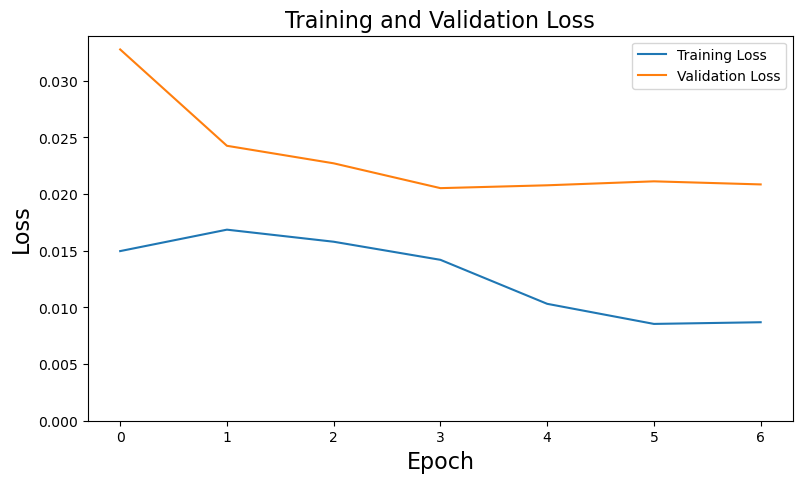

In [53]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize = 16)
plt.show()

Bu kod, modelin eğitim ve doğrulama kayıplarını (loss) görselleştiren bir grafik oluşturur. `matplotlib` kütüphanesi kullanılarak, modelin eğitim süreci sırasında kayıp değerlerinin nasıl değiştiğini gösteren bir çizgi grafiği çizilir. Kodun her bir bileşeni açıklaması aşağıdaki gibidir:

### Kodun Açıklaması

1. **`plt.figure(figsize=(20,5))`**: 
   - Grafik penceresinin boyutlarını ayarlar. Bu durumda, genişliği 20 inç ve yüksekliği 5 inç olan bir figür oluşturur. Bu genişlik ve yükseklik, grafiğin daha geniş ve daha kısa olmasını sağlar.

2. **`plt.subplot(1,2,2)`**:
   - Birden fazla grafik varsa, bu kod grafiğin hangi alt alanda çizileceğini belirtir. Burada `1,2,2`, bir satır ve iki sütunlu bir düzen içinde ikinci alt grafiği (sağdaki) seçer. Yani, bu grafik ikinci subplot olarak yerleştirilecektir.

3. **`plt.plot(history.history['loss'], label='Training Loss')`**:
   - Eğitim kaybını (loss) çizen bir çizgi grafiği oluşturur. `history.history['loss']`, modelin her epoch'taki eğitim kayıplarını içerir ve bu değerler grafikte "Training Loss" etiketi ile gösterilir.

4. **`plt.plot(history.history['val_loss'], label='Validation Loss')`**:
   - Doğrulama kaybını çizen bir çizgi grafiği oluşturur. `history.history['val_loss']`, modelin her epoch'taki doğrulama kayıplarını içerir ve bu değerler grafikte "Validation Loss" etiketi ile gösterilir.

5. **`plt.legend(loc='upper right')`**:
   - Grafikteki etiketlerin (legend) konumunu ayarlar. Bu durumda, etiketler grafiğin sağ üst köşesinde yer alır.

6. **`plt.xlabel('Epoch', fontsize=16)`**:
   - X ekseninin etiketini "Epoch" olarak ayarlar ve etiketin yazı boyutunu 16 olarak belirler.

7. **`plt.ylabel('Loss', fontsize=16)`**:
   - Y ekseninin etiketini "Loss" olarak ayarlar ve etiketin yazı boyutunu 16 olarak belirler.

8. **`plt.ylim([0, max(plt.ylim())])`**:
   - Y ekseninin sınırlarını belirler. Y ekseninin alt sınırını 0 olarak ayarlar ve üst sınırı, mevcut en yüksek değerine göre ayarlar. Bu, kayıp değerlerinin 0'dan başlayıp en yüksek değere kadar olan aralığı kapsamasını sağlar.

9. **`plt.title('Training and Validation Loss', fontsize=16)`**:
   - Grafiğin başlığını "Training and Validation Loss" olarak ayarlar ve başlığın yazı boyutunu 16 olarak belirler.

10. **`plt.show()`**:
    - Grafiği ekranda gösterir. Tüm yukarıdaki ayarlarla birlikte grafik, eğitim ve doğrulama kayıplarının nasıl değiştiğini görsel olarak sunar.

Bu kod, modelin eğitim süreci sırasında hem eğitim hem de doğrulama kayıplarını karşılaştırmak için görsel bir araç sağlar ve modelin performansını analiz etmek için kullanılır.

**Model Başarı Değerlendirme**

In [54]:
loss = model.evaluate(X_test, y_test, batch_size = 1)
print("\nTest loss : %.1f%%"%(100*loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0166

Test loss : 2.1%


In [55]:
train_predict = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [56]:
test_predict = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [57]:
# Verileri 2D hale getir
y_train_2d = y_train.reshape(-1, 1)
y_test_2d = y_test.reshape(-1, 1)

# Veri dönüşümünü uygula
y_train = scaler_train.inverse_transform(y_train_2d)
y_test = scaler_test.inverse_transform(y_test_2d)

# Tahmin sonuçlarını geri dönüştür
train_predict = scaler_train.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler_test.inverse_transform(test_predict.reshape(-1, 1))

# RMSE hesapla
from sklearn.metrics import mean_squared_error
import numpy as np

# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print(f"Train RMSE : {train_rmse}")
print(f"Test RMSE : {test_rmse}")


Train RMSE : 24.113988876342773
Test RMSE : 46.353641510009766


In [58]:
train_prediction_df = result_df[lookback:position]
train_prediction_df["Predicted"] = train_predict

In [59]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,133.190048
1949-03-01,132.0,137.738174
1949-04-01,129.0,149.493454
1949-05-01,121.0,146.840927
1949-06-01,135.0,140.031693


In [60]:
train_prediction_df['Predicted'] = train_predict
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,133.190048
1949-03-01,132.0,137.738174
1949-04-01,129.0,149.493454
1949-05-01,121.0,146.840927
1949-06-01,135.0,140.031693


In [61]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df['Predicted'] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,335.636292
1957-03-01,356.0,326.221924
1957-04-01,348.0,371.171387
1957-05-01,355.0,364.098053
1957-06-01,422.0,370.287231


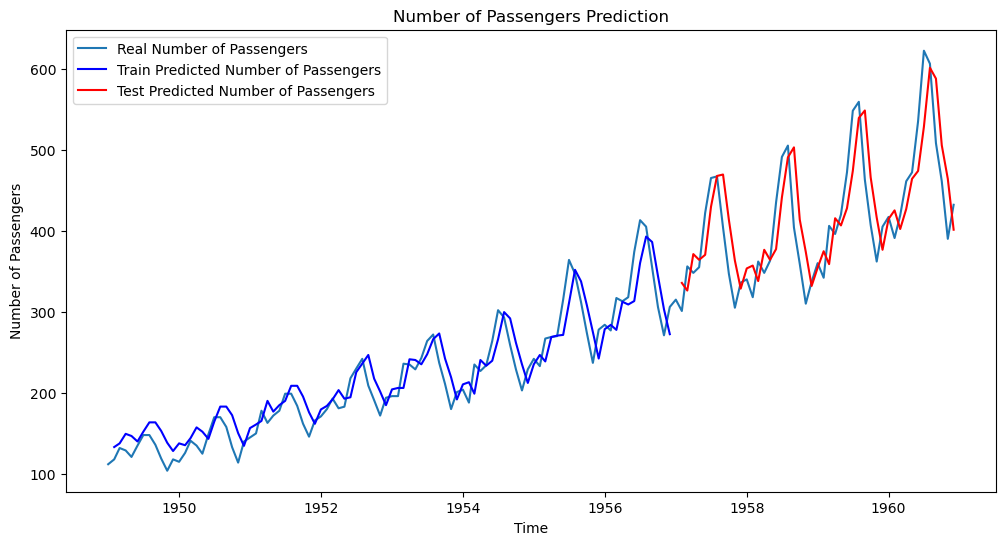

In [62]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(12,6))
plt.plot(result_df, label = 'Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color = 'blue', label = 'Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color = 'red', label = 'Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()